# Mixture of Gaussians

This notebook contains the code used to run the experiments of the Mixture of Gaussians section in the 'BR-SNIS' paper (https://arxiv.org/abs/2207.06364). 

In [8]:
import sys
sys.path.append(sys.path[0].replace('/notebooks', ''))
print(sys.path)

from typing import Tuple
from torch import ones, diag, inf, arange, Tensor, zeros, eye, no_grad, DeviceObjType, tensor, cat, rand, from_numpy, FloatTensor
from torch.distributions import Categorical, MixtureSameFamily, MultivariateNormal, Distribution
from torch.linalg import norm
from pyro.distributions import MultivariateStudentT
from typing import Union, Callable
import numpy as np
from br_snis import br_snis, snis
from functools import partial
from tqdm import tqdm
from torch import randint, from_numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from math import floor
import sys
import math
from scipy.stats import wasserstein_distance



def full_f(x, rectangle_1_coordinates, rectangle_2_coordinates):
    center_first, heights_first = rectangle_1_coordinates
    center_second, heights_second = rectangle_2_coordinates
    is_in_first_rectangle = norm((x - center_first[None, :]) / heights_first[None, :], ord=inf, dim=-1) < 1
    is_in_second_rectangle = norm((x - center_second[None, :]) / heights_second[None, :], ord=inf, dim=-1) < 1

    return is_in_first_rectangle.float() - is_in_second_rectangle.float()


def build_f(d: int = 7,
            device: Union[DeviceObjType, str] = 'cpu') -> Callable[[Tensor], Tensor]:
    heights_first = ones(d, device=device)*2
    heights_first[1] = .5
    heights_first[2:] *= .5
    center_first = zeros(d, device=device)
    center_first[0] = -4

    heights_second = ones(d, device=device)
    heights_second[0]=.25
    heights_second[1]=.5
    heights_second[2:] *= .1
    center_second = zeros(d, device=device)
    center_second[1] = 1.5
    center_second[0] = 1

    f = partial(full_f,
                rectangle_1_coordinates=(center_first, heights_first),
                rectangle_2_coordinates=(center_second, heights_second))
    return f


def build_params(d, device):
    mu_1 = zeros(d, device=device)
    mu_2 = zeros(d, device=device)
    mu_1[0:2] = 1
    mu_2[0]= -2
    sigma_1 = ones(d, device=device) / d
    sigma_2 = ones(d, device=device) / d
    return mu_1, mu_2, diag(sigma_1), diag(sigma_2)


def get_pi_dist(p, mus, sigmas):
    mix = Categorical(tensor([p, 1-p], device=mus.device))
    return MixtureSameFamily(mix,
                             MultivariateNormal(mus, sigmas))


def get_lambda_dist(nu, d, device):
    return MultivariateStudentT(loc=zeros(d, device=device), scale_tril=eye(d, device=device), df=nu)


def get_toy_problem_distributions(p: int = 1/3,
                                  nu: int = 3,
                                  dim: int = 7,
                                  device: Union[str, DeviceObjType] ='cpu') -> Tuple[Distribution, Distribution]:
    mu_1, mu_2, sigma_1, sigma_2 = build_params(dim, device=device)
    pi = get_pi_dist(p,
                     cat([mu_1.unsqueeze(0), mu_2.unsqueeze(0)]),
                     cat([sigma_1.unsqueeze(0), sigma_2.unsqueeze(0)]))
    lda = get_lambda_dist(nu, d=dim, device=device)

    return pi, lda


def mse_from_samples(samples, real_value, n_for_mean):
    reshaped_samples = samples.reshape(-1, n_for_mean)
    return ((reshaped_samples - real_value) ** 2).mean(dim=-1)



def compute_snis_estimators(log_weights,
                            f_values,
                            n_particles,
                            n_chains,
                            n_epochs,
                            device):
    snis_estimators = []
    total_size_per_batch = n_particles * n_chains
    
    for i in tqdm(range(n_epochs),
                  desc="SNIS"):
        start = randint(high=all_f_values.shape[0] - total_size_per_batch, size=(1,)).item()
        perm = arange(start, start + total_size_per_batch)
        
        estimations = snis(f_values=f_values[perm].reshape(n_chains, n_particles, 1).to(device),
                           log_weights=log_weights[perm].reshape(n_chains,n_particles).to(device)).cpu().flatten()
        snis_estimators.append(estimations)
        
    snis_estimators = cat(snis_estimators)
    return snis_estimators


def compute_br_snis_estimators(log_weights,
                               f_values,
                               n_chains,
                               n_epochs,
                               br_snis_settings,
                               device):
    #### br_snis estimations ####
    br_snis_estimations = {}
    
    for (minibatch_size, k, n_bootstrap) in br_snis_settings:
        
        br_snis_estimations[(minibatch_size, k, n_bootstrap)] = []
        
        total_budget = minibatch_size*k
        total_size_per_batch = total_budget * n_chains

        for i in tqdm(range(n_epochs),
                      desc=f'BR-SNIS N = {minibatch_size+1}, k: {k}, n_bootstrap: {n_bootstrap}'):
            start = randint(high=all_f_values.shape[0] - total_size_per_batch,
                            size=(1,)).item()
            perm = arange(start,
                             start + total_size_per_batch)
            estimations = br_snis(k_max=k,
                                  n_particles=minibatch_size,
                                  f_values=f_values[perm].reshape(n_chains, total_budget, 1).to(device),
                                  log_weights=log_weights[perm].reshape(n_chains, total_budget).to(device),
                                  n_bootstrap=n_bootstrap).cpu()
            br_snis_estimations[(minibatch_size, k, n_bootstrap)].append(estimations[..., 0].mean(dim=-1))
        br_snis_estimations[(minibatch_size, k, n_bootstrap)] = cat(br_snis_estimations[(minibatch_size, k, n_bootstrap)],
                                                                    dim=1)
    return br_snis_estimations


rc_context = {'axes.edgecolor': 'black',
              'ytick.color': 'black',
              'xtick.color': 'black',
              'axes.labelcolor': 'black',
              'axes.titlecolor': 'black',
              'legend.fontsize': 22,
              'font.size': 22,
              'figure.subplot.right': 0.98,
              'figure.subplot.top': .98,
              'figure.subplot.bottom': .10,
              'figure.subplot.left': 0.12,
              'lines.markersize': 15,
              'lines.linewidth': 3,
              'xtick.labelsize': 'x-large',
              }

['/home/gcardoso/projets/br_snis/notebooks', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/gcardoso/projets/venv/lib/python3.8/site-packages', '/home/gcardoso/projets/br_snis', '/home/gcardoso/projets/br_snis']


In [2]:
device = 'cuda:7' # cpu 
target, proposal = get_toy_problem_distributions(device=device)
f = build_f(device=device)
n_total_particles = 10_000_000_000
n_batch = 500_000
with no_grad():
    all_log_weights = []
    all_f_values = []
    for i in tqdm(range(n_total_particles // n_batch), desc="Generating samples"):
        particles = proposal.sample((n_batch,))
        log_weights = target.log_prob(particles) - proposal.log_prob(particles)
        f_values = f(particles)

        all_log_weights.append(log_weights.squeeze(0).cpu())
        all_f_values.append(f_values.squeeze(0).cpu())

del particles, log_weights, f_values
if device != 'cpu':
    from torch.cuda import empty_cache
    empty_cache()
    
all_log_weights = cat(all_log_weights).cpu()
all_f_values = cat(all_f_values).cpu()

Generating samples: 100%|█████████████████████████████████████████████████████| 20000/20000 [01:47<00:00, 185.96it/s]


In [3]:
ref_value = snis(log_weights=all_log_weights.reshape(1, -1),
                 f_values=all_f_values.reshape(1, -1, 1)).item()

## Performance Comparison

In this section we reproduce the experiments used to generate the images present in the main numerical part of the paper.

In [4]:
total_budget = 16384
n_replications = 1_000_000

In [5]:
estimations_snis = compute_snis_estimators(all_log_weights,
                                           all_f_values,
                                           total_budget,
                                           n_replications // 10, # number of parallel chains in one run 
                                           10,
                                           device) # n runs

SNIS: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.93s/it]


In [9]:
estimations_brsnis = compute_br_snis_estimators(all_log_weights,
                                                all_f_values,
                                                n_replications // 50,
                                                50,
                                                [(128, total_budget // 128, total_budget // 128),
                                                (512, total_budget // 512, total_budget // 512)],
                                                device)

BR-SNIS N = 513, k: 32, n_bootstrap: 32: 100%|███████████████████████████████████████| 50/50 [03:07<00:00,  3.75s/it]


/home/gcardoso/projets/venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/gcardoso/projets/venv/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


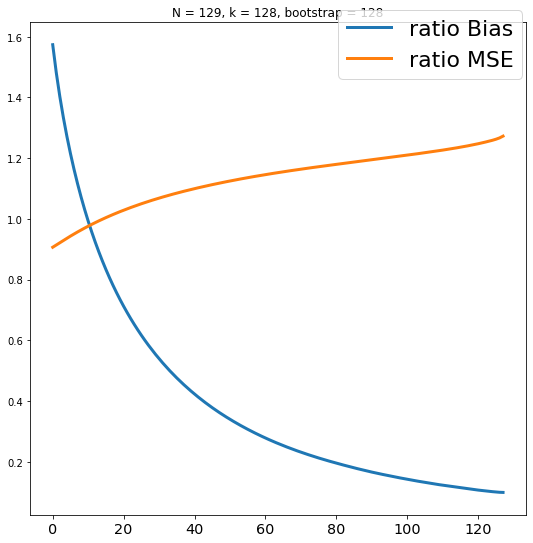

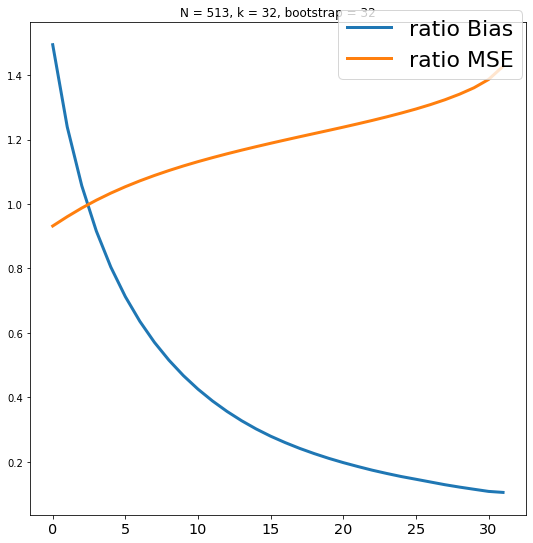

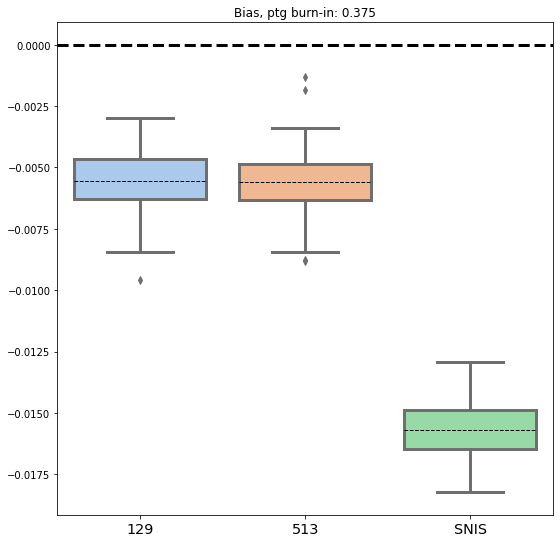

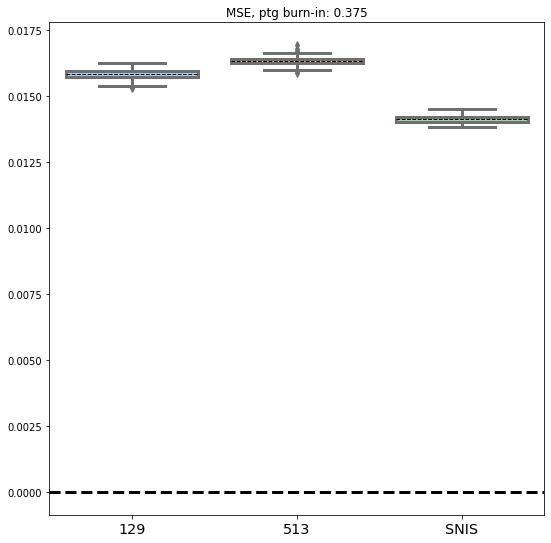

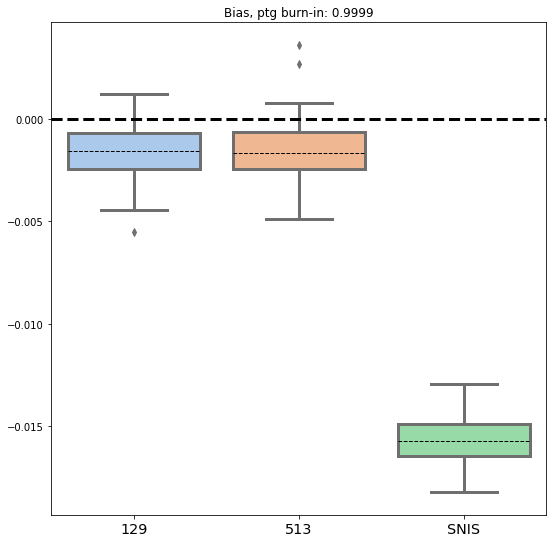

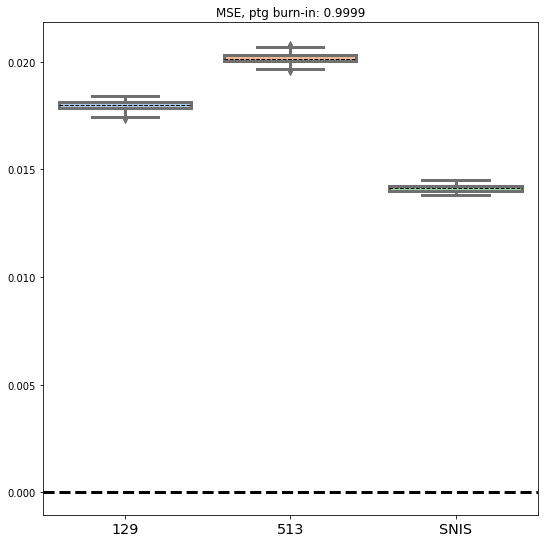

In [11]:
burn_in_percentages = [.375, .9999]
n_for_mean = 10_000 # how many replications are going to be used for one estimation

with plt.rc_context(rc_context):
    mse_snis = mse_from_samples(estimations_snis, ref_value, len(estimations_snis))
    
    for (minibatch, k, n_bootstrap), estimation_brsnis in estimations_brsnis.items():
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.plot([(estimation_brsnis[i:].mean(dim=0).mean() - ref_value) / (estimations_snis.mean() - ref_value) for i in
                 range(0, estimation_brsnis.shape[0])],
                label='ratio Bias')
        ax.plot(
            [mse_from_samples(estimation_brsnis[i:].mean(dim=0), ref_value,
                              estimation_brsnis.shape[1]).item() / mse_snis for i
             in range(0, estimation_brsnis.shape[0])], label='ratio MSE')
        ax.set_title(f'N = {minibatch + 1}, k = {k}, bootstrap = {n_bootstrap}')
        fig.legend()
        fig.show()
        
    for ptg in burn_in_percentages:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        sns.boxplot(
            data=[est[min(floor(est.shape[0] * ptg), est.shape[0] - 1):].mean(dim=0).reshape(-1, n_for_mean).mean(axis=-1) - ref_value
                  for est in estimations_brsnis.values()] +
                 [estimations_snis.reshape(-1, n_for_mean).mean(dim=-1) - ref_value],
            showmeans=True,
            meanline=True,
            medianprops={"linewidth": 0},
            meanprops={"color": "black"},
            ax=ax,
            palette='pastel',
        )
        ax.set_xticklabels([str(i + 1) for (i, j, k) in estimations_brsnis.keys()] + ['SNIS'])
        ax.axhline(0, color='black', linestyle='dashed')
        ax.set_title(f'Bias, ptg burn-in: {ptg}')
        fig.show()

        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        sns.boxplot(
            data=[mse_from_samples(est[min(floor(est.shape[0] * ptg), est.shape[0] - 1):].mean(dim=0), ref_value, n_for_mean) for
                  est in estimations_brsnis.values()] +
                 [mse_from_samples(estimations_snis, ref_value, n_for_mean)],
            showmeans=True,
            meanline=True,
            medianprops={"linewidth": 0},
            meanprops={"color": "black"},
            ax=ax,
            palette='pastel',
        )
        ax.set_xticklabels([str(i + 1) for (i, j, k) in estimations_brsnis.keys() if i != 256] + ['SNIS'])
        ax.axhline(0, color='black', linestyle='dashed')
        ax.set_title(f'MSE, ptg burn-in: {ptg}')
        fig.show()


### Bootstrap

The experiments below illustrate the effect of bootstrapping the estimators

In [13]:
estimations_brsnis_bootstrap = compute_br_snis_estimators(all_log_weights,
                                                        all_f_values,
                                                        n_replications // 25,
                                                        25,
                                                        [(128, total_budget // 128, 1),
                                                        (128, total_budget // 128, 10),
                                                        (128, total_budget // 128, 64),
                                                        (128, total_budget // 128, 128)],
                                                         device=device)

BR-SNIS N = 129, k: 128, n_bootstrap: 128: 100%|█████████████████████████████████████| 25/25 [09:48<00:00, 23.53s/it]


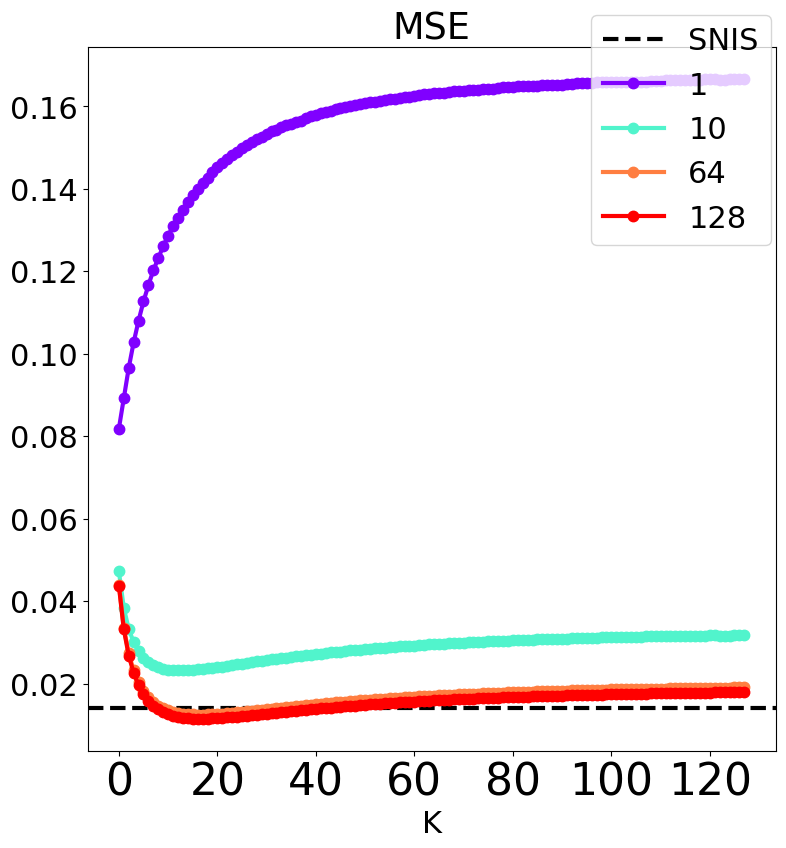

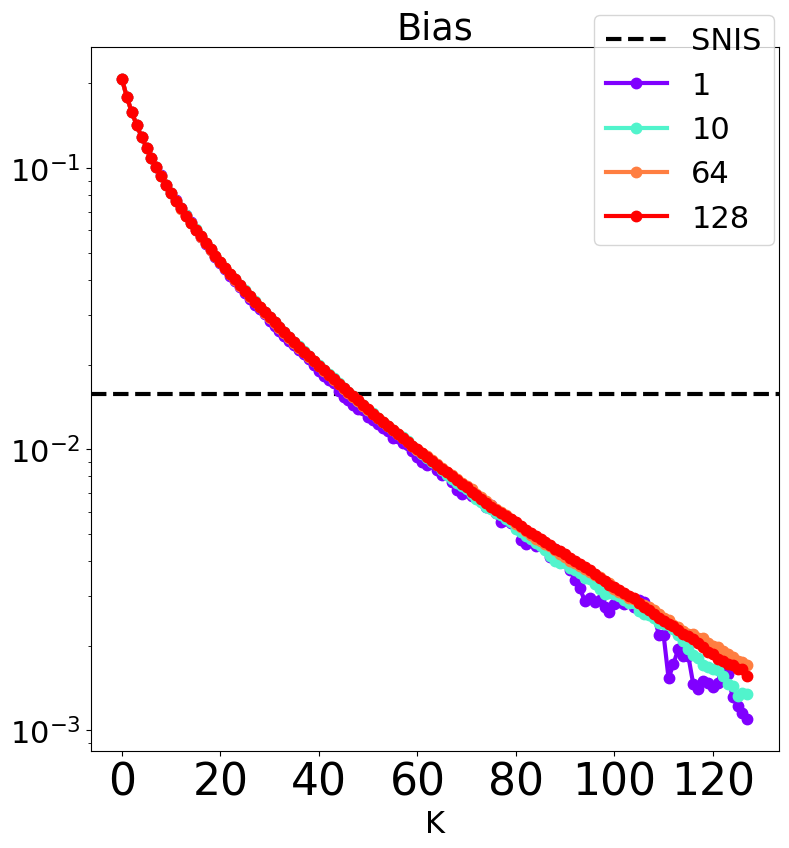

In [14]:
min_n = min(i[-1] for i in estimations_brsnis_bootstrap.keys())
max_n = max(i[-1] for i in estimations_brsnis_bootstrap.keys())
cmap = lambda x: cm.rainbow((np.log(x + 1) - np.log(min_n + 1)) / (np.log(max_n + 1) - np.log(min_n + 1)))
with plt.rc_context(rc_context):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    mse_snis = ((estimations_snis - ref_value)**2).mean()
    ax.axhline(mse_snis, linestyle='dashed', color='black', label='SNIS')
    for (_, _, n_bootstrap), exps in estimations_brsnis_bootstrap.items():
        mse = (exps - ref_value)**2
        ax.plot(mse.mean(dim=-1),
                color=cmap(n_bootstrap), marker='.', label=str(n_bootstrap))
    ax.set_xlabel('K')
    ax.set_title(f'MSE')
    fig.legend()
    fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    bias_snis = ((estimations_snis - ref_value)).mean(dim=0)
    ax.axhline(bias_snis.abs(), linestyle='dashed', color='black', label='SNIS')
    for (_, _, n_bootstrap), exps in estimations_brsnis_bootstrap.items():
        estimators = exps
        bias = (estimators - ref_value)
        ax.plot(np.abs(bias.mean(dim=-1)), color=cmap(n_bootstrap), marker='.', label=str(n_bootstrap))
    ax.set_xlabel('K')
    ax.set_yscale('log')
    ax.set_title('Bias')
    fig.legend()
    fig.show()

### Theorem Bounds

We then proceed to an illustration of the theorem bounds. Note that the estimations are done without bootstrap.

In [41]:
def plot_bias(expectations_through_time,
              real_value,
              snis,
              colormap=cm.rainbow,
              limit_max=200,
              n_subdivisions=10):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for (n, _, _), data in expectations_through_time.items():
        color = colormap(n)
        n_subdivision_data = min(n_subdivisions, data.shape[0] - 1)
        max_value = min(limit_max, data.shape[0])
        ks = np.linspace(1, max_value - 1, n_subdivision_data).astype(int)

        to_bp = [data[k, :] for k in ks]
        means = np.array([(bp.mean() - real_value).abs().item() for bp in to_bp])
        reg = LinearRegression().fit(ks.reshape(-1, 1),
                                     np.log(means))
        b, a = reg.intercept_, reg.coef_
        ax.scatter(ks, means, color=color, label=f'N = {n}')

        ax.plot(ks, np.exp(b + a * ks),
                linestyle='dashed',
                color=color,
                )
    ax.axhline(0, color='r', alpha=.3)
    ax.axhline(np.abs(snis.mean() - real_value), linestyle='dashed', color='g', alpha=.7, label='SNIS')

    #ax.set_ylabel(r'$|\mathbb{E}_{\xi}[\Pi_{N}f(X^{1:N}_{k})] - \pi(f)|$', fontsize=24)

    ax.set_xlabel(r'$K$')

    ax.set_title(f'Bias')
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.legend()
    fig.show()


def plot_covariance(chains_data,
                    real_value,
                    k_range,
                    l_range,
                    colormap=cm.rainbow):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for k in k_range:
        color = colormap((k - k_range.min()) / (k_range.max() - k_range.min()))
        ax.plot(((chains_data[:, k][:, None] - real_value) * (chains_data[:, k + l_range] - real_value)).mean(axis=0),
                label=f'K = {k}',
                color=color,
                linestyle='--',
                markersize=10)

    ax.set_yscale('log')
    #ax.set_ylabel(r'$Cov(k, \ell)$',
    #              fontsize=24)

    ax.set_title(f'Covariance')
    ax.set_xlabel(r'$\ell$')
    ax.legend()
    fig.show()


def plot_mse(expectations_through_time,
             real_value,
             snis,
             colormap=cm.rainbow):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    k_max = 1
    for (n, _, _), data in expectations_through_time.items():
        color = colormap(n)
        ks = np.arange(1, data.shape[0])  # , min(9, data.shape[1])).astype(int)
        to_bp = [data[k, :] for k in ks]
        mse = np.array([((bp - real_value) ** 2).mean() for bp in to_bp])
        k_max = max(data.shape[0], k_max)
        ax.scatter(ks, mse, color=color, label=f'N = {n}')

    ax.axhline(0, color='r', alpha=.3)
    ax.axhline(((snis - real_value)**2).mean(), linestyle='dashed', color='g', alpha=.7, label='SNIS')

    ax.set_xlabel(r'$K$')
    ax.set_title(f'MSE')
    ax.set_xlim(10, k_max)
    ax.set_xscale('log')
    ax.legend()
    fig.show()


def plot_running_bias(expectations_through_time,
                      real_value,
                      snis,
                      colormap=cm.rainbow):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    estims = {}
    for upsilon in np.arange(1, 5) / 5:
        color = colormap(upsilon)
        estims[upsilon] = []
        k_0s = []
        for n, data in expectations_through_time.items():
            #data = np.array(data)
            k = data.shape[0]
            k_0 = math.floor(k * (1 - upsilon))
            estims[upsilon].append(np.abs(data[k_0 + 1:, :].mean(dim=0).mean(dim=0) - real_value))
            k_0s.append(k_0)

        ax.scatter(k_0s, estims[upsilon], color=color, label=r'$\upsilon$ $=$ ' + str(upsilon))

    ax.axhline(0, color='r', alpha=.3)
    ax.axhline(np.abs(snis.mean() - real_value), linestyle='dashed', color='g', alpha=.7, label='SNIS')

    #ax.set_ylabel(r'$|\mathbb{E}_{\xi}(\Pi_{N, K, K_0}f(X^{1:N}_{k}) - \pi(f)|$', fontsize=24)

    ax.set_xlabel(r'$K_0$')
    ax.set_title(f'Running bias')
    ax.set_xscale('log')
    ax.legend()
    fig.show()


def plot_running_mse(expectations_through_time,
                     real_value,
                     snis,
                     colormap=cm.rainbow):

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    estims = {}
    snis_mse = ((snis - real_value)**2).mean()
    ax.axhline(snis_mse, color='g', alpha=.7, label='SNIS')
    for upsilon in np.arange(1, 5) / 5:
        color = colormap(upsilon)
        estims[upsilon] = []
        Ns = []
        for n, data in expectations_through_time.items():
            data = np.array(data)
            k = data.shape[0]
            k_0 = math.floor(k * (1 - upsilon))
            estims[upsilon].append(((data[k_0 + 1:, :].mean(axis=0) - real_value)**2).mean(axis=0))
            
            Ns.append(n[0])
        #ax.axhline(snis_mse/upsilon, color=color, alpha=.7, linestyle='dashed')
        ax.scatter(Ns, estims[upsilon], color=color, label=r'$\upsilon$ $=$ ' + str(upsilon))

    ax.axhline(0, color='r', alpha=.3)

    #ax.set_ylabel(r'$\mathbb{E}_{\xi}[(\Pi_{N, K, K_0}f(X^{1:N}_{k} - \pi(f))^2]$', fontsize=24)

    ax.set_xlabel(r'$M$')

    ax.set_title(f'Running MSE')
    ax.set_xscale('log')
    ax.legend()
    fig.show()



In [28]:
total_budget = 2**14
n_replications = 1_000_000#_000
estimations_snis = compute_snis_estimators(all_log_weights,
                                           all_f_values,
                                           total_budget,
                                           n_replications // 25,#00, # number of parallel chains in one run 
                                           25,
                                           device)#00) # n runs


SNIS: 100%|██████████████████████████████████████████████████████████████████████████| 25/25 [01:08<00:00,  2.73s/it]


In [29]:
empty_cache()

In [30]:
estimations_brsnis = compute_br_snis_estimators(all_log_weights,
                                                all_f_values,
                                                n_replications // 10,
                                                10,
                                                [(n, total_budget // n, 1) for n in 2**np.arange(5, 10)],
                                                device)



BR-SNIS N = 513, k: 32, n_bootstrap: 1: 100%|████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]


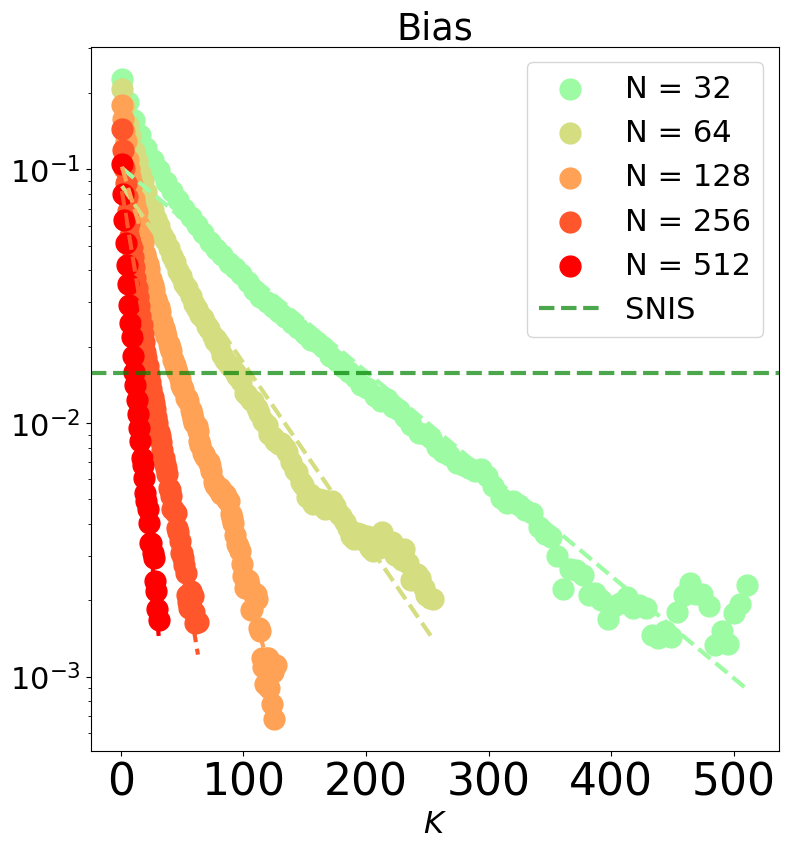

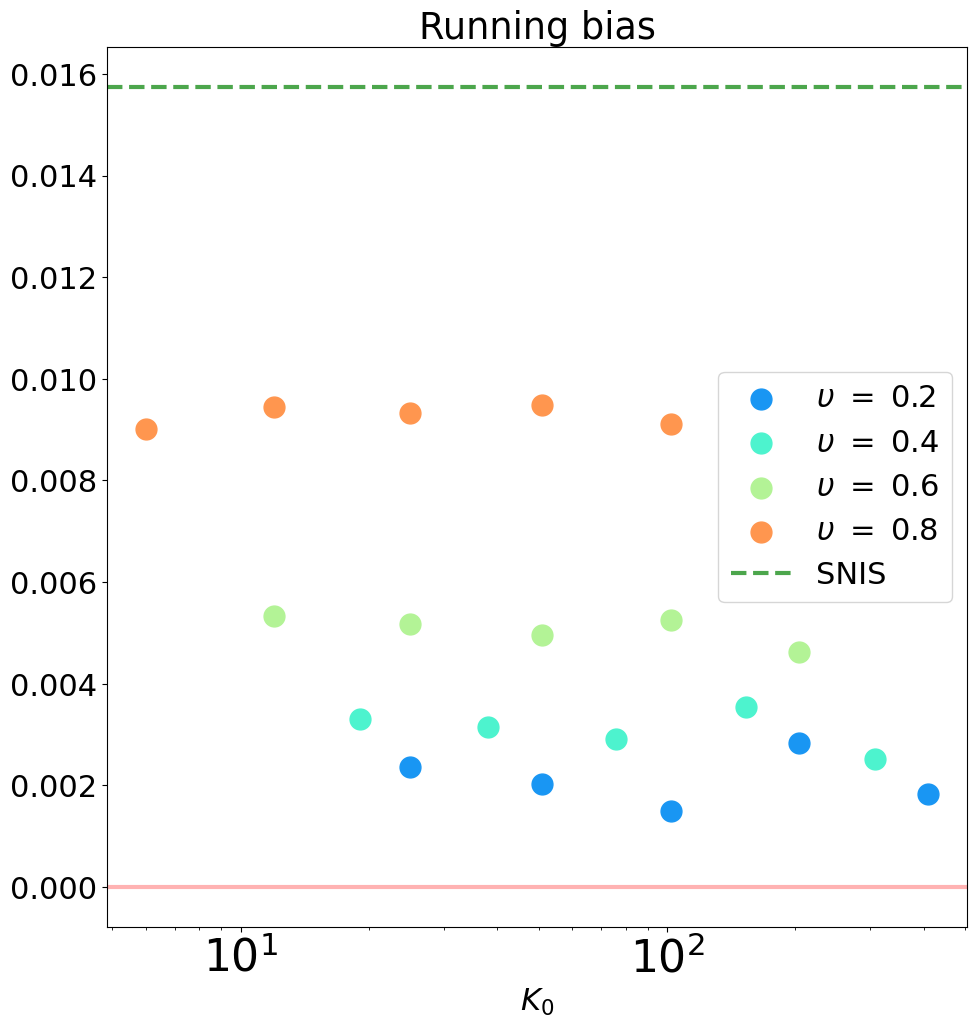

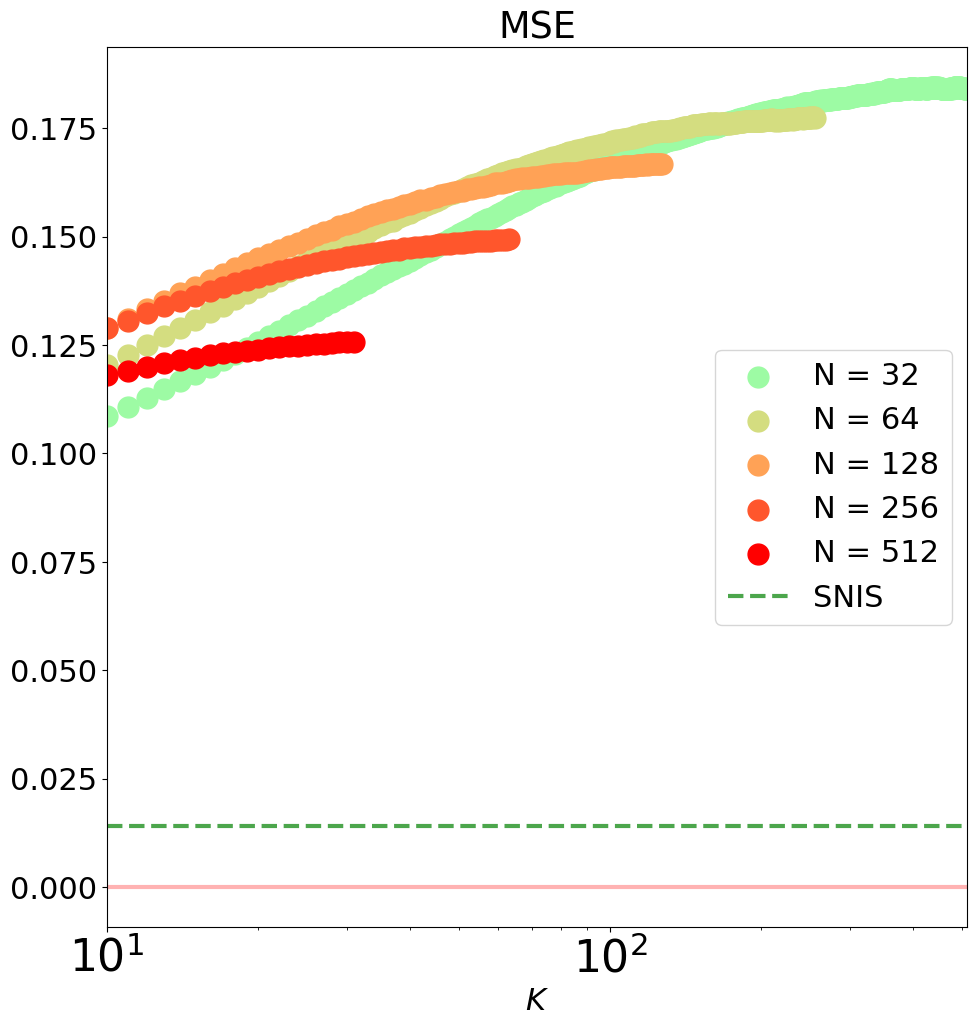

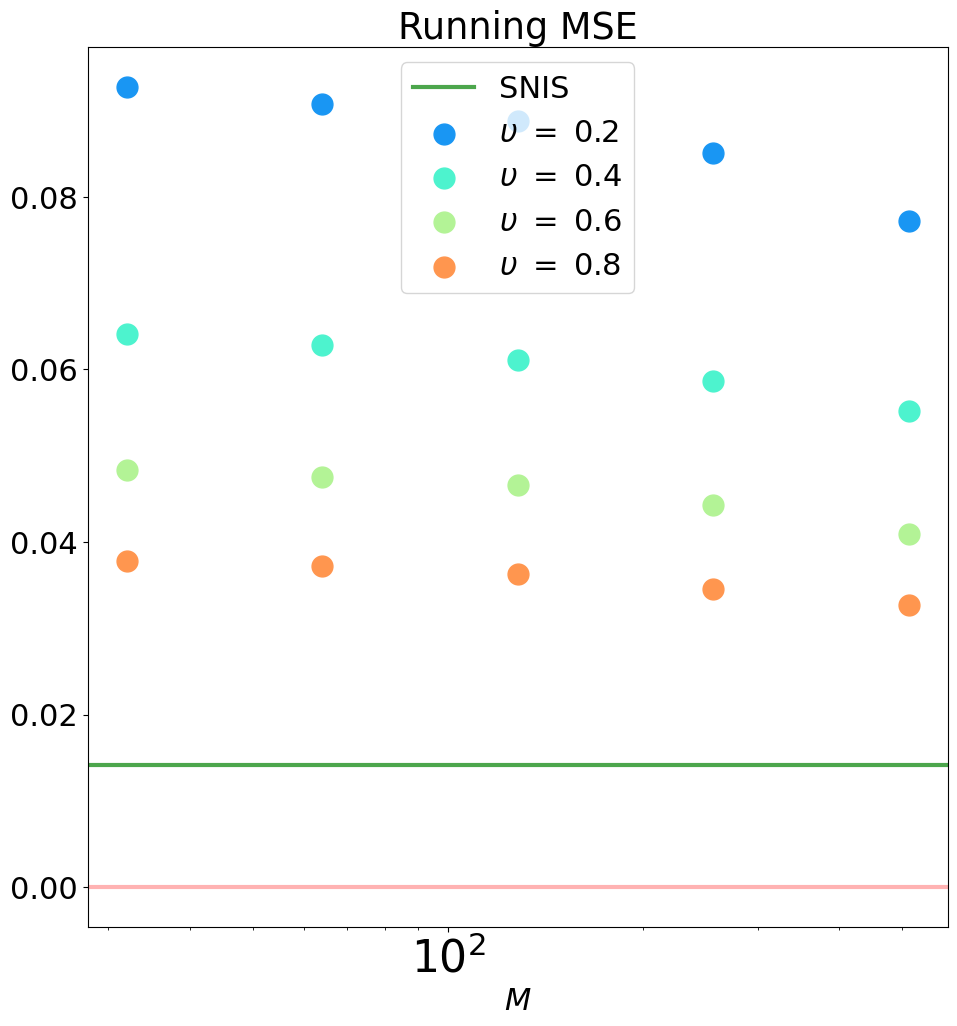

In [42]:
max_N = max([i[0] for i in estimations_brsnis.keys()])
colormap_N = lambda x: cm.rainbow(np.log2(x) / np.log2(max_N))
with plt.rc_context(rc_context):

    plot_bias(estimations_brsnis,
              real_value=ref_value,
              snis=estimations_snis,
              colormap=colormap_N,
             limit_max=5000,
              n_subdivisions=100)
    plot_running_bias(estimations_brsnis,
                      real_value=ref_value,
                      snis=estimations_snis)
    plot_mse(expectations_through_time=estimations_brsnis,
             snis=estimations_snis,
              real_value=ref_value,
             colormap=colormap_N)
    plot_running_mse(estimations_brsnis,
                     real_value=ref_value,
                     snis=estimations_snis)

    #